## * In this notebook I would like to analyse and undertand the data and bring out few insights on relation between existing features

## Importing Data and Libraries

In [2]:
import plotly
import plotly.express as px
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import gc   # garbage collector
import pickle
from tqdm.auto import tqdm
import time
from joblib import Parallel, delayed
from sklearn.metrics import f1_score,confusion_matrix,\
                            precision_recall_fscore_support,classification_report,\
                            accuracy_score,log_loss
from sklearn.model_selection import train_test_split


In [4]:
orders = pd.read_csv('orders.csv') #Null values in days_since_prior_order
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
dep = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')

## Data Cleaning

1. Checking for any duplicate values.

2. Finding and Fixing any missing values.

3. Finding and Fixing any Garbage/incorrect values.

In [5]:
print(aisles.duplicated().any())
print(dep.duplicated().any())
print(products.duplicated().any())
print(orders.duplicated().any())
print(order_products_prior.duplicated().any())
print(order_products_train.duplicated().any())

False
False
False
False
False
False


### Observation:
 There are no duplicates in any tables

------------------------------------------------------------------------------

In [6]:
print(aisles.isnull().any())
print(dep.isnull().any())
print(products.isnull().any())
print(orders.isnull().any())
print(order_products_prior.isnull().any())
print(order_products_train.isnull().any())

aisle_id    False
aisle       False
dtype: bool
department_id    False
department       False
dtype: bool
product_id       False
product_name     False
aisle_id         False
department_id    False
dtype: bool
order_id                  False
user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
dtype: bool
order_id             False
product_id           False
add_to_cart_order    False
reordered            False
dtype: bool
order_id             False
product_id           False
add_to_cart_order    False
reordered            False
dtype: bool


In [7]:
orders=orders[orders['days_since_prior_order'].notnull()]


##Merging Tables.


In [8]:
# merging orders, order_products_prior and order_products_train
order_products = pd.concat([order_products_prior,order_products_train],ignore_index=True)
data = orders.merge(order_products,on='order_id')
data.sort_values(['user_id','order_number','add_to_cart_order'],inplace=True, axis='index',\
                 ignore_index=True)
data

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2398795,1,prior,2,3,7,15.0,196,1,1
1,2398795,1,prior,2,3,7,15.0,10258,2,0
2,2398795,1,prior,2,3,7,15.0,12427,3,1
3,2398795,1,prior,2,3,7,15.0,13176,4,0
4,2398795,1,prior,2,3,7,15.0,26088,5,1
...,...,...,...,...,...,...,...,...,...,...
31741033,272231,206209,train,14,6,14,30.0,40603,4,0
31741034,272231,206209,train,14,6,14,30.0,15655,5,0
31741035,272231,206209,train,14,6,14,30.0,42606,6,0
31741036,272231,206209,train,14,6,14,30.0,37966,7,0


In [9]:
prod_info = products.merge(dep,on='department_id')
prod_info=prod_info.merge(aisles,on='aisle_id')
prod_info

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes
...,...,...,...,...,...,...
49683,22827,Organic Black Mission Figs,18,10,bulk,bulk dried fruits vegetables
49684,28655,Crystallized Ginger Chunks,18,10,bulk,bulk dried fruits vegetables
49685,30365,Vegetable Chips,18,10,bulk,bulk dried fruits vegetables
49686,38007,Naturally Sweet Plantain Chips,18,10,bulk,bulk dried fruits vegetables


# EDA

---



---



#### Q. How many orders are in each set?
- CountPlot of no. of orders in each eval_set.

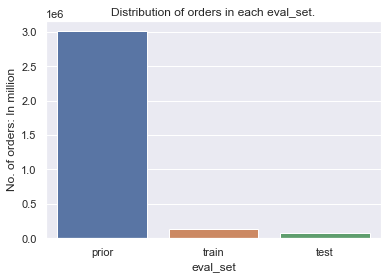

In [10]:
sns.countplot(x='eval_set',data=orders)
plt.title('Distribution of orders in each eval_set.')
plt.ylabel('No. of orders: In million');

**Coclusion:**
- Prior set has more than 3 million orders.
- Train set has more than 0.1 million orders.
- Eval set has less than 0.1 million orders



---



---



---



#### Q. How many users each set(train/test)?
- CountPlot of no. of users in train and test set.

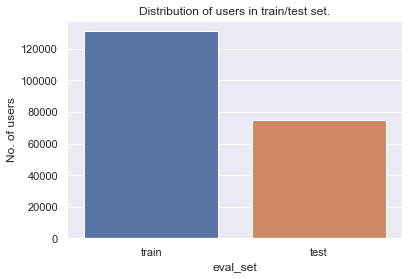

In [11]:
sns.countplot(x='eval_set',data=orders.loc[~orders.eval_set.str.contains('prior'),:])
plt.title('Distribution of users in train/test set.')
plt.ylabel('No. of users');

**Conclusion:**
- Around 130K users belong to train set.
- Around 75K users belong to test set.



---




---



#### Q. How many users placed n number of orders?

CountPlot of no. of users who place n number of orders.

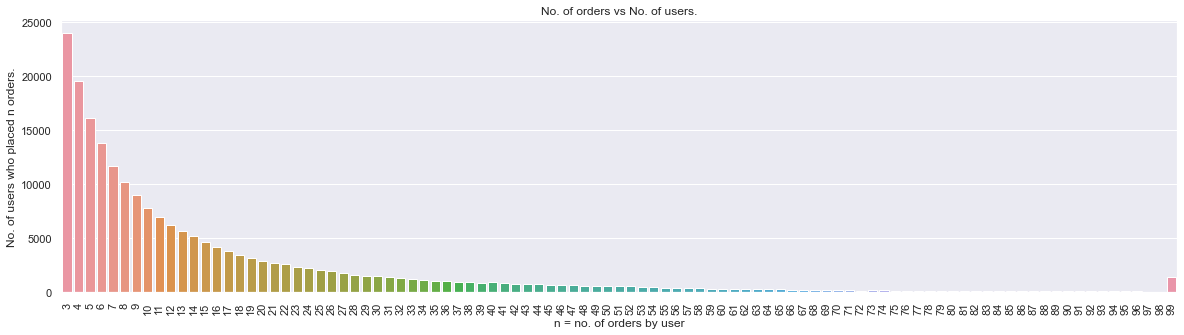

In [12]:
num_of_orders_per_user = orders.groupby('user_id').size()\
                                .rename('#orders')\
                                .sort_values()\
                                .reset_index()
fig,ax = plt.subplots(figsize=(20,5))
sns.countplot(data=num_of_orders_per_user, x='#orders',ax=ax)
plt.title('No. of orders vs No. of users.')
plt.xlabel('n = no. of orders by user')
plt.ylabel('No. of users who placed n orders.')
plt.xticks(rotation=90);

> **Conclusion:**
- Each user has placed atleast 4 orders.
- Most users have placed 4-15 orders.
- Each user places between 4-100 orders.
- There is a sharp decrease in number of users as no. of orders increase.



---



---





#### Q. How many orders have n number of products?
- CountPlot of number of orders with n number of products.

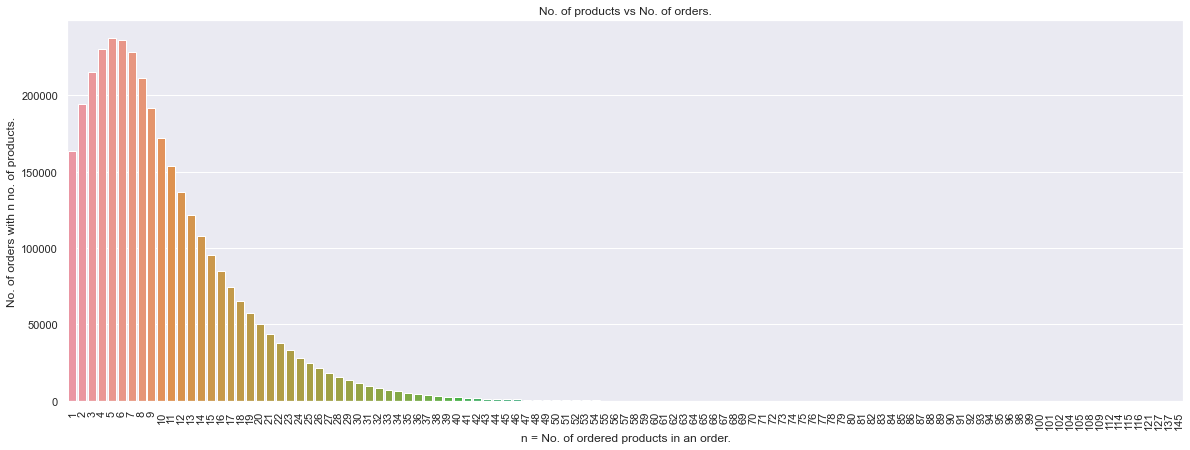

In [13]:
num_of_prods_per_order = order_products.groupby('order_id').size()\
                                        .rename('#products')\
                                        .sort_values()\
                                        .reset_index()
fig,ax = plt.subplots(figsize=(20,7))
sns.countplot(data=num_of_prods_per_order, x='#products',ax=ax)
plt.title('No. of products vs No. of orders.')
plt.xlabel('n = No. of ordered products in an order.')
plt.ylabel('No. of orders with n no. of products.')
plt.xticks(rotation=90);

> **Conclusion:**
- Customers usually tend to buy less than 20 products in an order.
- Most orders have 5-6 products.



---



---



#### Q. How many orders have n number of reordered products?
- Countplot of No. of orders with n no. of reordered products.

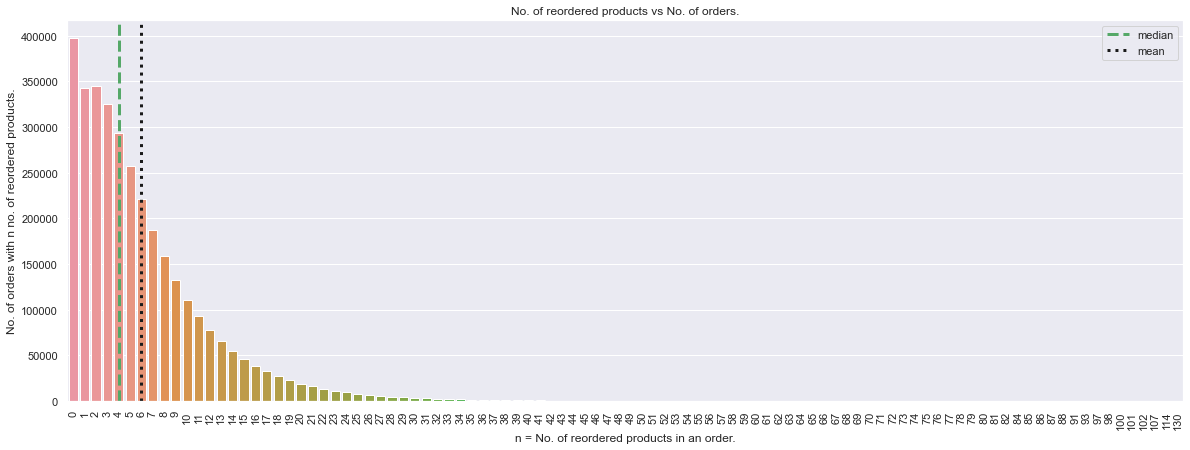

In [14]:
num_of_reordered_prods_per_order = (
    order_products.groupby('order_id')['reordered'].sum()
                    .rename('#reordered_products')
                    .sort_values()
                    .reset_index()
    )
fig,ax = plt.subplots(figsize=(20,7))
sns.countplot(data=num_of_reordered_prods_per_order,x='#reordered_products',ax=ax,);
plt.axvline(num_of_reordered_prods_per_order['#reordered_products'].median(),ls='--',color='g',lw=3,label='median')
plt.axvline(num_of_reordered_prods_per_order['#reordered_products'].mean(),ls=':',color='k',lw=3,label='mean')
plt.title('No. of reordered products vs No. of orders.')
plt.xlabel('n = No. of reordered products in an order.')
plt.ylabel('No. of orders with n no. of reordered products.')
plt.legend()
plt.xticks(rotation=90);

> **Conclusion:**
- Most customers like to reorder 1-10 products in an order. 


---



---



#### Q. What was the distribution of probability of reorder in all orders?
- Histplot of probability of reorder over all orders.

In [15]:
order_info = data.groupby('order_id')['reordered'].agg(['sum','count','mean'])
order_info.tail()

,sum,count,mean
order_id,,,
3421078,7,9,0.777778
3421079,0,1,0.000000
3421080,4,9,0.444444
3421082,4,7,0.571429
3421083,4,10,0.400000


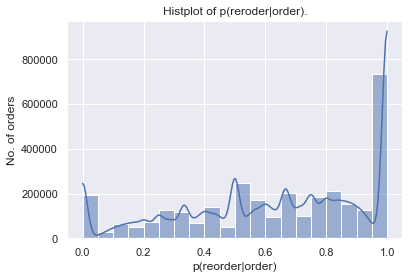

In [16]:
sns.histplot(data=order_info, x='mean',kde=True,binwidth=0.05,)
plt.xlabel('p(reorder|order)')
plt.ylabel('No. of orders')
plt.title('Histplot of p(reroder|order).');

**Conclusion:**
- Most orders have either all reordered products or None reordered products.
- Lot of None reordered products because first order has 0 reordered products.
- More orders have probability of reorder more than 0.5.






---



---






---



---



#### Q. What is the average no. of reorders per department?
- BarPlot of Avg no. of reorders per department. 

$$ \text{#avg_reorders} = \frac{\sum \text{No. of reorders from the dep.}}{ \text{No. of distinct products in the department}}$$


In [17]:
dep_info = order_products.merge(prod_info, on='product_id', how='right')\
                .groupby(['department_id','product_id'],as_index=False)\
                ['reordered'].sum()\
                .rename(columns={'reordered':'#reorders'})
dep_info = dep_info.groupby('department_id',as_index=False)\
                    .agg({'#reorders':'mean'})\
                    .rename(columns={'#reorders': '#avg_reorders'})
dep_info = dep.merge(dep_info,on='department_id')      

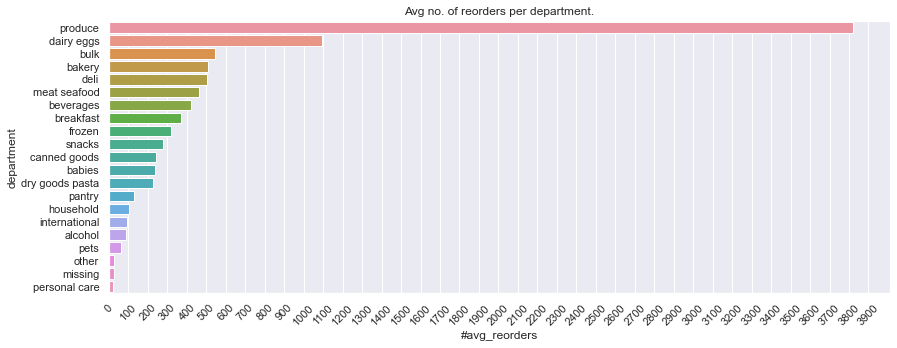

In [18]:
fig,ax = plt.subplots(figsize=(14,5))
sns.barplot(data=dep_info.sort_values(['#avg_reorders'],ascending=False),
            x='#avg_reorders',
            y='department',
            ax=ax);
plt.xticks(np.arange(0,4000,100),rotation=45)
plt.title('Avg no. of reorders per department.');

**Conclusion:**
- Produce department's products are highly reordered.
- Personal Care, missing & other departments' products are not reordered much.- All departments with high avg no. of reorders belong to eatable group.
- Produce department alone has a very very high avg no. of reorders.
- Produce and dairy eggs departments combined have more avg no. of reorders than all other departments combined. This could be because Produce and dairy eggs departments contain daily needs products.
- Personal care, other and missing departments have very low avg no. of reorders.



---



---



#### Q. What is the  probability of reorder of each department?
- BarPlot of p(reorder|department) over each departmnent.

$$\text{p(reorder|department)} = \frac{\text{#reorders from the dep.}}{\text{#purchases from the dep.}} $$

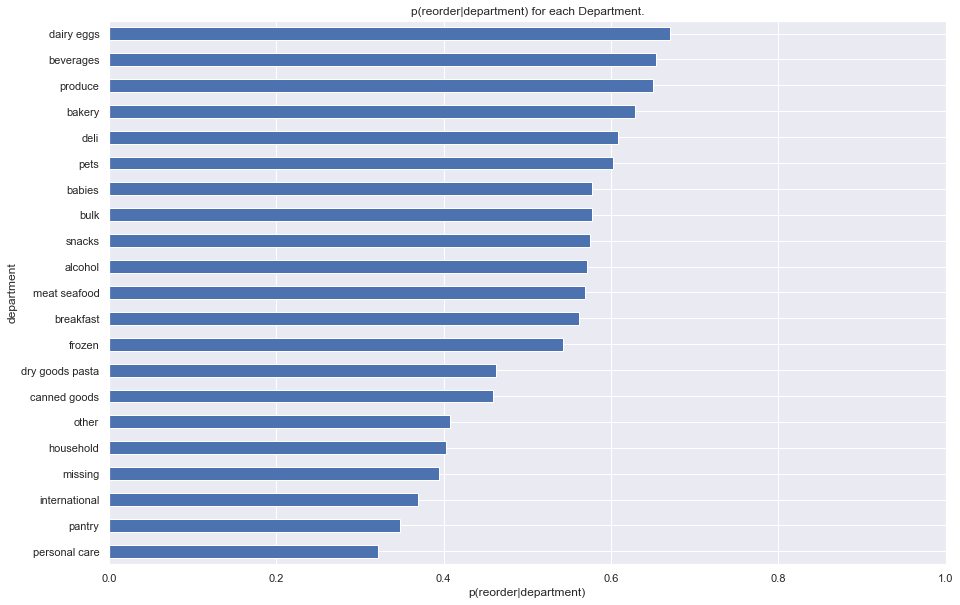

In [19]:
order_products.merge(prod_info,on='product_id')\
                .groupby(['department'])['reordered'].mean()\
                .sort_values()\
                .plot(kind='barh',
                      figsize=(15,10),
                      grid=True,);
plt.xlabel('p(reorder|department)')
plt.title('p(reorder|department) for each Department.')
plt.xlim(0,1);

**Conclusion:**
- All the top departments belong the eatables group.
- Among all "dairy eggs" department has the highest probability of reorder.
- Diary eggs, beverages and produce department are among the top in both sales numbers and probability of reorder.
- Departments having probability of reorder less than 0.5 are disliked by customers because the #reordered products sold is less than #not_reordered products sold.
- canned goods, dry goods pasta, household, international, pantry, Personal care, missing and other departments are disliked by customers.
- Personal care department has a very large variety of products but probability of reorder of this department is very low.





---



---



#### Q. What is the average no. of reorders per aisle?
- BarPlot of Avg no. of reorders per aisle. 

$$ \text{#avg_reorders} = \frac{\sum \text{No. of reorders from the aisle}}{ \text{No. of distinct products in the aisle}}$$

In [20]:
aisle_info = order_products.merge(prod_info, on='product_id', how='right')\
                .groupby(['aisle_id','product_id'],as_index=False)\
                ['reordered'].sum()\
                .rename(columns={'reordered':'#reorders'})
aisle_info = aisle_info.groupby('aisle_id',as_index=False)\
                    .agg({'#reorders':'mean'})\
                    .rename(columns={'#reorders': '#avg_reorders'})
aisle_info = aisles.merge(aisle_info,on='aisle_id')             

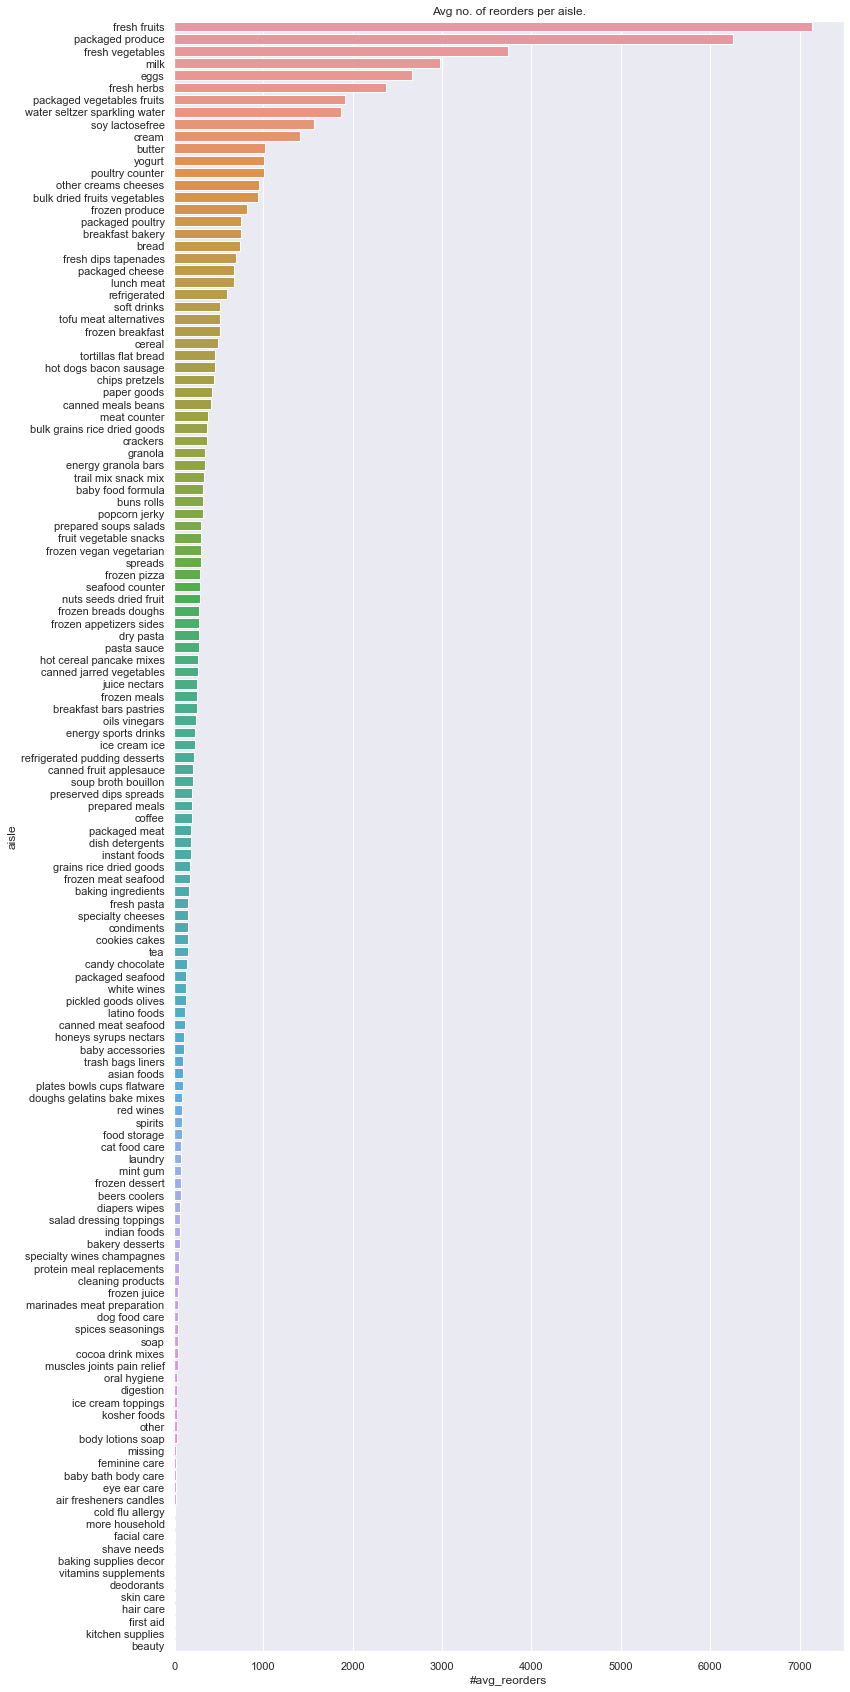

In [21]:
fig,ax = plt.subplots(figsize=(12,30))
sns.barplot(data=aisle_info.sort_values(['#avg_reorders'],ascending=False),
            x='#avg_reorders',
            y='aisle',
            ax=ax);
#plt.xticks(np.arange(0,4000,100),rotation=45)
plt.title('Avg no. of reorders per aisle.');

**Conclusion:**
- Again the aisles containing the daily needs eatable products have a very high avg no. of reorders than personal care and other type of products.






---



---



#### Q. How many orders were placed over each day of week?
- CountPlot of number of orders over each order_dow(day of week).

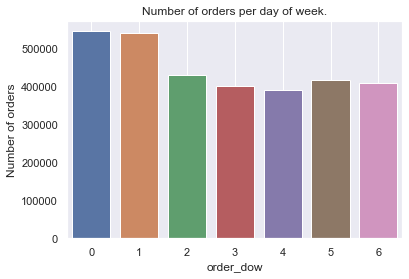

In [22]:
sns.countplot(x='order_dow',data=orders.loc[orders.eval_set.astype(str)!='test',:])
plt.title('Number of orders per day of week.')
plt.ylabel('Number of orders')
plt.grid()
plt.show()

> **Conclusion:**
- Day 0 and 1 of week are the most popular of purchasing.



---



---



#### Q. What is the probability of reorder on each day of week?

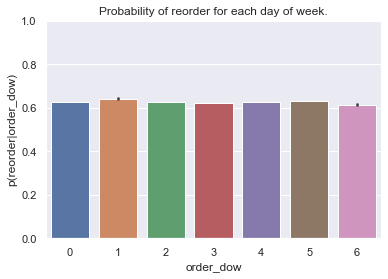

In [23]:
sns.barplot(x='order_dow',y='reordered',data=data, estimator=np.mean, orient='v')
plt.ylabel('p(reorder|order_dow)')
plt.title('Probability of reorder for each day of week.')
plt.ylim(0,1);

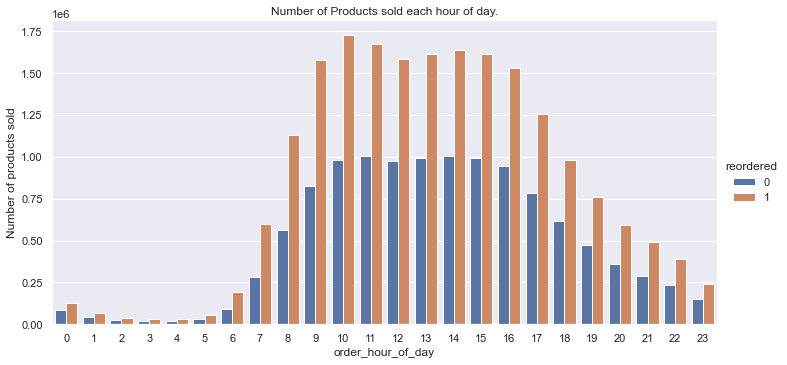

In [24]:
sns.catplot(x='order_hour_of_day',hue='reordered',data=data,kind='count',aspect=2)
plt.ylabel('Number of products sold')
plt.title('Number of Products sold each hour of day.');



---



---



Q. How many products are reordered on each day of week and at each hour of day?
Heatmap of no. of reorders at each hour_of_day of each dow.

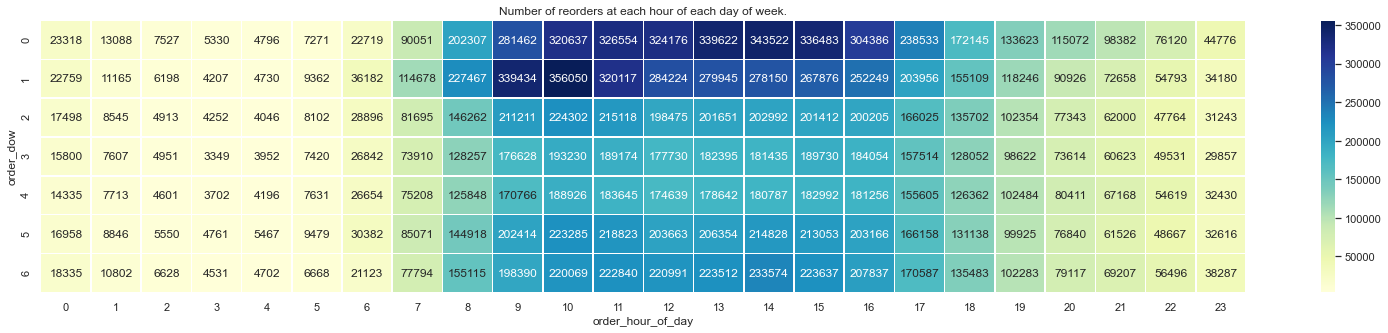

In [25]:
no_of_reorders_at_time = data.pivot_table(values='reordered',
                                          index='order_dow',
                                          columns='order_hour_of_day',
                                          aggfunc=sum)\
                                          .astype('int64')
fig, ax = plt.subplots(figsize=(27,5))
sns.heatmap(no_of_reorders_at_time,annot=True,fmt='d',linewidth=.5,cmap="YlGnBu",ax=ax)
plt.title('Number of reorders at each hour of each day of week.');

> **Conclusion:**
- Number 1 slot for reordering products is on day 0-1 of week between 8th and 17th hour of day.



---



---



Next we get the orders in terms of hour of the day and day of the week in a single dataset by using the groupby option for better visualization



In [26]:
orders_group = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()

orders_group.head(), orders_group.tail()

(   order_dow  order_hour_of_day  order_number
 0          0                  0          3690
 1          0                  1          2245
 2          0                  2          1296
 3          0                  3           902
 4          0                  4           756,
      order_dow  order_hour_of_day  order_number
 163          6                 19         17128
 164          6                 20         12486
 165          6                 21          9842
 166          6                 22          7973
 167          6                 23          5710)

In [27]:
#pivot table 
orders_group = orders_group.pivot(index = 'order_dow', columns = 'order_hour_of_day', values = 'order_number')
orders_group

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
0,3690,2245,1296,902,756,1093,3143,11762,26514,38363,...,51038,50427,46136,37056,27588,21126,17062,13577,10543,6460
1,3429,1723,1020,696,756,1523,5078,15725,32382,49136,...,43986,43590,41930,34407,27046,20687,15223,11196,8417,5245
2,2843,1472,878,683,696,1317,4511,12606,23343,34351,...,34946,35249,35239,30092,24797,18794,14045,10032,7649,4994
3,2760,1398,893,608,676,1279,4345,11775,21338,30578,...,32665,33878,33156,28483,23399,17991,12977,9681,7735,4867
4,2476,1415,841,644,695,1253,4184,11893,20682,29670,...,31696,32244,32034,27697,22935,18140,13326,10198,8275,5305
5,2987,1568,952,780,846,1502,4632,12770,22789,32342,...,35351,35379,33770,28131,22806,17517,12500,8945,7013,4926
6,3080,1815,1130,804,739,1056,3063,10696,21696,29012,...,36325,35608,33194,28342,22562,17128,12486,9842,7973,5710


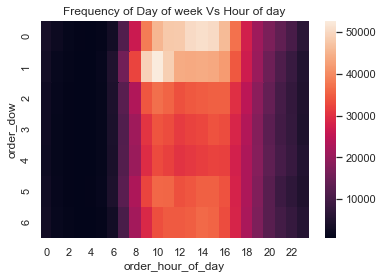

In [28]:
sns.heatmap(orders_group)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

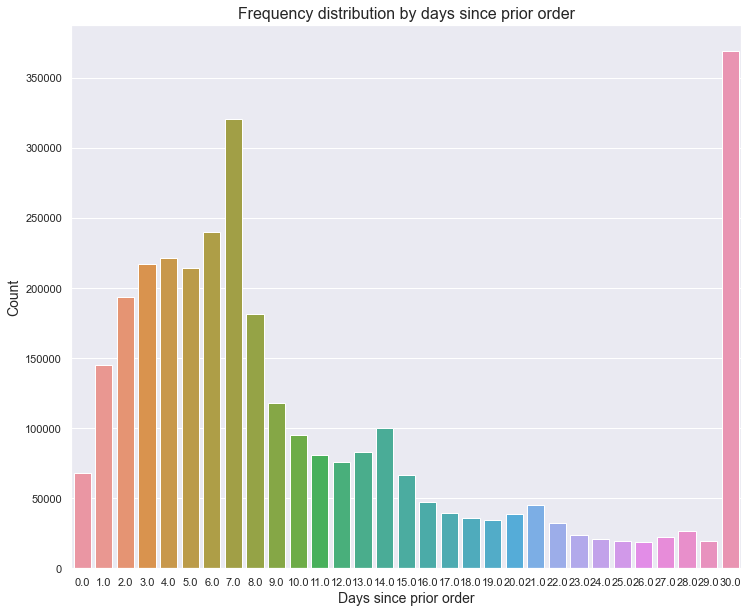

In [29]:
plt.figure(figsize=(12,10))
sns.countplot(x="days_since_prior_order", data=orders)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Days since prior order', fontsize=14)
plt.title("Frequency distribution by days since prior order", fontsize=16)
plt.show()

We observe that 7th day we have a spike followed by a small peak at days. Then there is spike on 14,21 and 28 days. This indicates that every 7 days or weekly is the order frequency. Also,there's a huge peak at the end of the month showing there's a monthly peak.



### correaltion for variable selection

<AxesSubplot:>

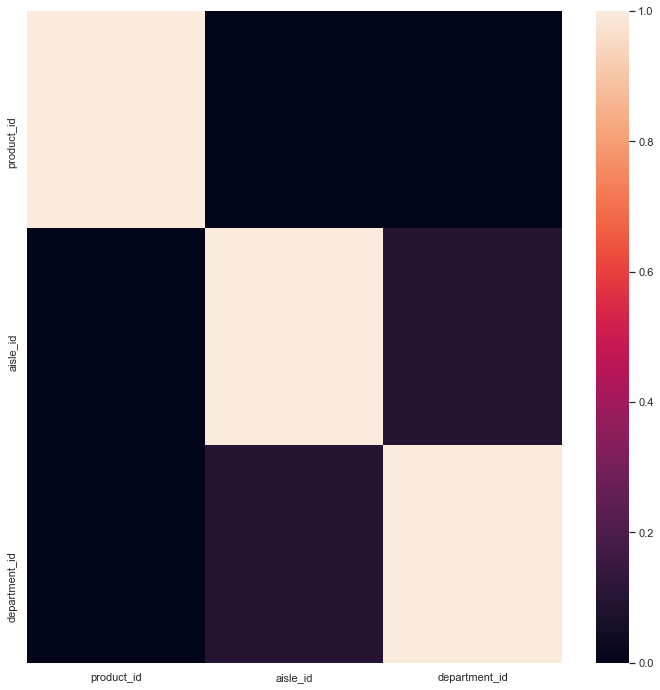

In [30]:
corr = products.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

<AxesSubplot:>

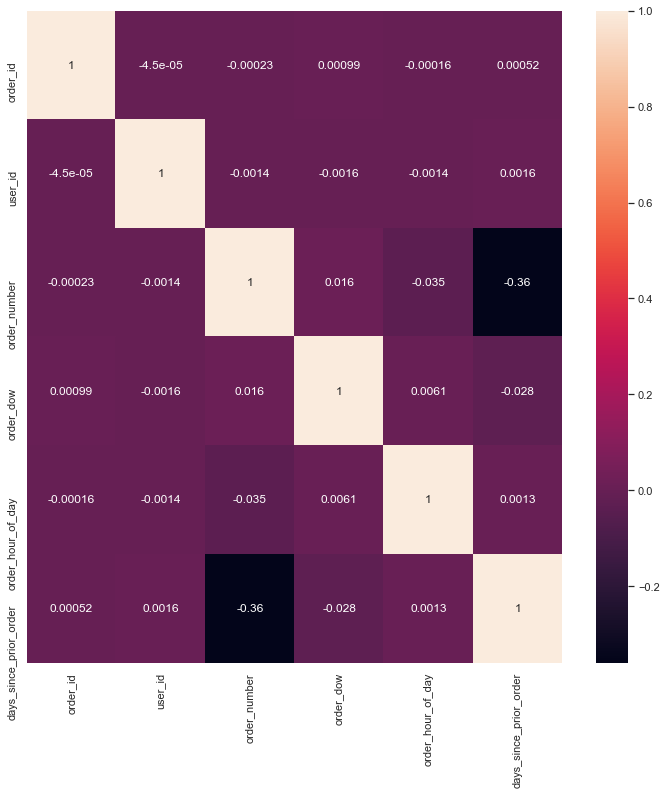

In [31]:
plt.figure(figsize=(12,12))
corr_orders = orders.corr()
sns.heatmap(corr_orders, 
            xticklabels=corr_orders.columns.values,
            yticklabels=corr_orders.columns.values,annot=True)